<a href="https://colab.research.google.com/github/parishwadomkar/Investigating-machine-learning-for-simulating-urban-transport-patterns/blob/main/Ensemble%20Regression%20Model%20and%20SHAP%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Regressor Machine Learning Model

## Installing libraries

     |████████████████████████████████| 575 kB 6.9 MB/s 


## Import necessary libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from collections import defaultdict
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt 
import sys
import copy
import shap
import os.path
import array as arr
import pickle
from matplotlib import rcParams
import sklearn
import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [ ]:
#Load parameters and data from '/content/'
os.chdir('/content/')

# Read Origin-Destination table from the csv , dtype={"people": "float64"}
df = pd.read_csv('/content/Data.csv', index_col=[0])
df.head()

,Day,Trips,OrigCode,DestCode,Origin,Destination,OPop,DEmpl,Ourban,Durban,OInc,DInc,Distance
289,Monday,39337,30101,30101,Gamle Oslo,Gamle Oslo,41736,43121,4.75,4.75,453000,453000,0.000000
290,Monday,7888,30101,30102,Gamle Oslo,Grünerløkka,41736,29560,4.75,3.65,453000,450000,2143.111352
291,Monday,2934,30101,30103,Gamle Oslo,Sagene,41736,19408,4.75,2.34,453000,461000,3837.411674
292,Monday,5553,30101,30104,Gamle Oslo,St. Hanshaugen,41736,54104,4.75,2.80,453000,430000,4360.828507
293,Monday,4279,30101,30105,Gamle Oslo,Frogner,41736,48082,4.75,5.35,453000,464000,5157.307531


### Dropping ```'index','Day','OrigCode','DestCode'``` columns



In [ ]:
df.reset_index(inplace=True)
df.drop(columns={'index','Day','OrigCode','DestCode'}, inplace=True)
df.head()

,Trips,Origin,Destination,OPop,DEmpl,Ourban,Durban,OInc,DInc,Distance
0,39337,Gamle Oslo,Gamle Oslo,41736,43121,4.75,4.75,453000,453000,0.000000
1,7888,Gamle Oslo,Grünerløkka,41736,29560,4.75,3.65,453000,450000,2143.111352
2,2934,Gamle Oslo,Sagene,41736,19408,4.75,2.34,453000,461000,3837.411674
3,5553,Gamle Oslo,St. Hanshaugen,41736,54104,4.75,2.80,453000,430000,4360.828507
4,4279,Gamle Oslo,Frogner,41736,48082,4.75,5.35,453000,464000,5157.307531


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Trips        289 non-null    int64  
 1   Origin       289 non-null    object 
 2   Destination  289 non-null    object 
 3   OPop         289 non-null    int64  
 4   DEmpl        289 non-null    int64  
 5   Ourban       289 non-null    float64
 6   Durban       289 non-null    float64
 7   OInc         289 non-null    int64  
 8   DInc         289 non-null    int64  
 9   Distance     289 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 22.7+ KB


## Exploratory Data Analysis

In [ ]:
Y = df['Trips']
X = df[['Origin', 'Destination', 'OPop', 'DEmpl', 'Ourban', 'Durban', 'OInc', 'DInc', 'Distance']]

In [ ]:
X.head()

,Origin,Destination,OPop,DEmpl,Ourban,Durban,OInc,DInc,Distance
0,Gamle Oslo,Gamle Oslo,41736,43121,4.75,4.75,453000,453000,0.000000
1,Gamle Oslo,Grünerløkka,41736,29560,4.75,3.65,453000,450000,2143.111352
2,Gamle Oslo,Sagene,41736,19408,4.75,2.34,453000,461000,3837.411674
3,Gamle Oslo,St. Hanshaugen,41736,54104,4.75,2.80,453000,430000,4360.828507
4,Gamle Oslo,Frogner,41736,48082,4.75,5.35,453000,464000,5157.307531


In [ ]:
Y.head()

0    39337
1     7888
2     2934
3     5553
4     4279
Name: Trips, dtype: int64

## Using label encoding

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
X['encOrigin'] = le.fit_transform(X['Origin'])
X['encDestination'] = le.fit_transform(X['Destination'])

In [ ]:
cityDict = {}
for i in range(len(X['Origin'].unique())):
  cityDict[X['encOrigin'].unique()[i]] = X['Origin'].unique()[i]
cityDict

{3: 'Gamle Oslo',
 5: 'Grünerløkka',
 9: 'Sagene',
 11: 'St. Hanshaugen',
 2: 'Frogner',
 14: 'Ullern',
 15: 'Vestre Aker',
 7: 'Nordre Aker',
 1: 'Bjerke',
 4: 'Grorud',
 12: 'Stovner',
 0: 'Alna',
 16: 'Østensjø',
 8: 'Nordstrand',
 13: 'Søndre Nordstrand',
 10: 'Sentrum',
 6: 'Marka'}

In [ ]:
X.drop(columns={'Origin', 'Destination'}, inplace=True)

In [ ]:
X.head()

,OPop,DEmpl,Ourban,Durban,OInc,DInc,Distance,encOrigin,encDestination
0,41736,43121,4.75,4.75,453000,453000,0.000000,3,3
1,41736,29560,4.75,3.65,453000,450000,2143.111352,3,5
2,41736,19408,4.75,2.34,453000,461000,3837.411674,3,9
3,41736,54104,4.75,2.80,453000,430000,4360.828507,3,11
4,41736,48082,4.75,5.35,453000,464000,5157.307531,3,2


### Spliting into train & test

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.15)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 190 to 140
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPop            245 non-null    int64  
 1   DEmpl           245 non-null    int64  
 2   Ourban          245 non-null    float64
 3   Durban          245 non-null    float64
 4   OInc            245 non-null    int64  
 5   DInc            245 non-null    int64  
 6   Distance        245 non-null    float64
 7   encOrigin       245 non-null    int64  
 8   encDestination  245 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 19.1 KB


In [ ]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 11 to 5
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPop            44 non-null     int64  
 1   DEmpl           44 non-null     int64  
 2   Ourban          44 non-null     float64
 3   Durban          44 non-null     float64
 4   OInc            44 non-null     int64  
 5   DInc            44 non-null     int64  
 6   Distance        44 non-null     float64
 7   encOrigin       44 non-null     int64  
 8   encDestination  44 non-null     int64  
dtypes: float64(3), int64(6)
memory usage: 3.4 KB


## Training vanila XGBRegressor

In [ ]:
model = None

# train the model
model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=0)
model.fit(x_train, y_train)

# extract the training set predictions
model.predict(x_train)

array([1.32457336e+03, 5.95155884e+02, 1.75133496e+03, 1.92067480e+03,
       3.02447281e+01, 1.45765381e+02, 4.77902832e+03, 2.13725037e+02,
       7.30798950e+01, 1.24120654e+03, 2.41217456e+03, 8.58133972e+02,
       7.35495911e+02, 4.50935760e+02, 2.97527695e+01, 1.25511560e+03,
       5.61167725e+02, 7.12084103e+00, 7.76425781e+02, 4.52059912e+03,
       2.11773125e+04, 2.05332703e+02, 4.77902832e+03, 1.16115857e+03,
       1.76633377e+02, 2.42835205e+03, 1.34586499e+03, 6.36512695e+02,
       1.03860123e+02, 1.84172422e+04, 3.30105972e+01, 1.77305939e+02,
       1.05472527e+02, 5.64901611e+02, 8.26482056e+02, 9.81147766e+00,
       2.00130212e+03, 4.31172559e+03, 1.50910681e+03, 6.56903015e+02,
       5.30046997e+02, 1.22229446e+02, 1.48991728e+01, 1.54959106e+03,
       7.76188782e+02, 5.78640381e+02, 4.95130035e+02, 6.33224854e+02,
       1.47142419e+03, 8.13241821e+02, 2.04639816e+02, 2.48281128e+03,
       1.80608789e+03, 2.64340894e+03, 2.60224075e+01, 1.20872949e+03,
      

### Training scores from vanilla XGBR

In [ ]:
# xgbr = None
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.9963469689388709


In [ ]:
scores = cross_val_score(xgbr, x_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.88


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.90


In [ ]:
ypred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print(f'mse: ', mse , '\nrmse: ',mse**(1/2) )

mse:  408042.96741495264 
rmse:  638.78241007009


## Hyperparameter optimisation
Using RandomisedSearchCV instead of GridCV

In [ ]:
regressor=xgb.XGBRegressor(objective="reg:squarederror")
n_estimators = [100,500,900,1100,1500]
max_depth = [2,3,5,10,15]
booster = ['gbtree', 'gblinear']
learning_rate = [0.05, 0.1, 0.15, 0.2]
min_child_weight = [1,2,3,4]
base_score = [0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
}

random_cv= RandomizedSearchCV(estimator=regressor,param_distributions=hyperparameter_grid,
                             cv=10, n_iter=50, scoring='neg_mean_absolute_error',
                             n_jobs=4, verbose=2, return_train_score=True,
                             random_state=123)

random_result = random_cv.fit(x_train, y_train)
random_result

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=XGBRegressor(objective='reg:squarederror'),
                   n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=123, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(f'The best score is {random_result.best_score_:.4f}')
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is -883.1578
The best hyperparameters are {'n_estimators': 900, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'booster': 'gbtree', 'base_score': 0.5}


## Training with best hyperparameters

In [ ]:
base_score = 0.5
n_estimators = 900
learning_rate = 0.05
min_child_weight = 1
max_depth = 3
booster = 'gbtree'

regressor = xgb.XGBRegressor(base_score=base_score, booster=booster, colsample_bylevel=1,colsample_bynode=1,colsample_bytree=1,
                             enable_categorical=False,gamma=0, importance_type=None,interaction_constraints='',
                             learning_rate=learning_rate, max_delta_step=0,max_depth=max_depth, min_child_weight=min_child_weight,
                             n_estimators=n_estimators, n_jobs=8,num_parallel_tree=1, predictor='gpu_predictor',random_state=0,
                             reg_alpha=0,reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
                             validate_parameters=1, verbosity=0)
regressor.fit(x_train,y_train)                           

XGBRegressor(enable_categorical=False, importance_type=None,
             interaction_constraints='', learning_rate=0.05, n_estimators=900,
             n_jobs=8, num_parallel_tree=1, predictor='gpu_predictor',
             tree_method='exact', validate_parameters=1, verbosity=0)

### Scores

In [ ]:
ypred = regressor.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print(f'mse: ', mse , '\nrmse: ',mse**(1/2) )

mse:  343642.4970021348 
rmse:  586.2102839443666


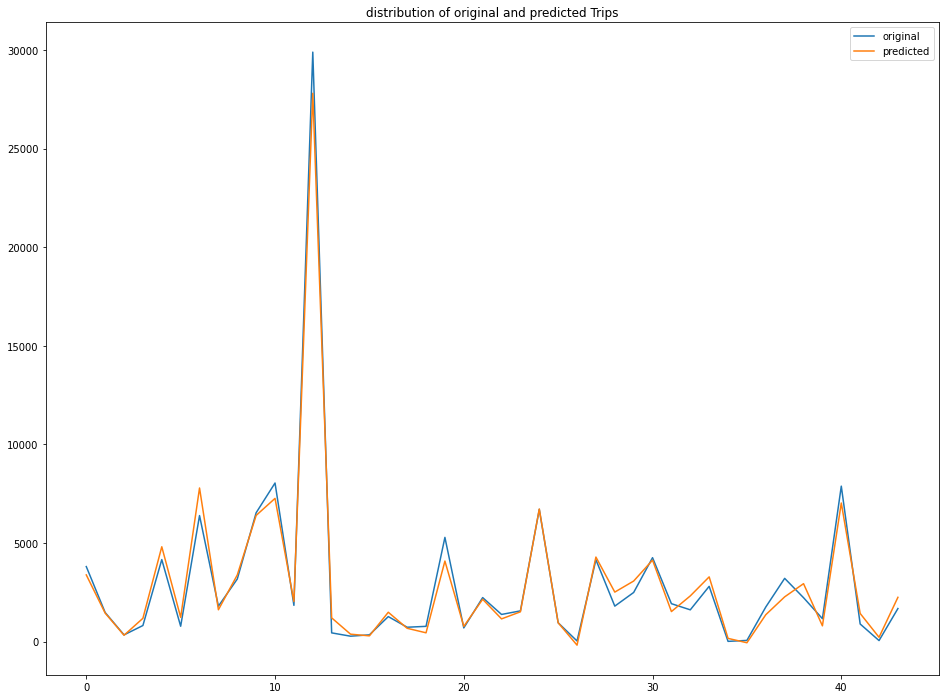

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("distribution of original and predicted Trips")
plt.legend()
rcParams['figure.figsize'] = 16,12
plt.show()

In [ ]:
#After training the model, we'll check the model training score.
scores = cross_val_score(regressor, x_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.89


In [ ]:
regressor.fit(x_train,y_train)
predictions = regressor.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 586.210284


In [ ]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.991940


# SHAP ANALYSIS

### SHAP values

In [ ]:
explainer = shap.TreeExplainer(regressor)
sv = explainer.shap_values(x_test)

###  Summary plots
***We can visualize the importance of the features and their impact on the prediction by plotting summary charts.***

In the plots below the features are also sorted by their effect on prediction, but we can also see how higher and lower values of the feature will affect the result. It also uses SHAP values to show the distribution of the impacts each feature has.



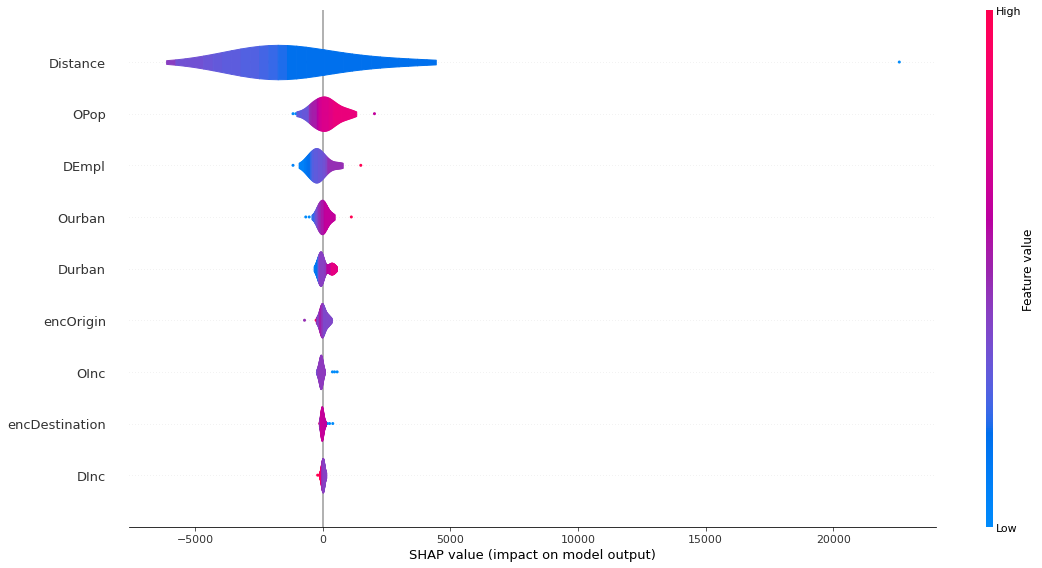

In [ ]:
shap.summary_plot(sv,  x_test, plot_type='violin', plot_size=(16,8))

In [ ]:
shap.summary_plot(sv,  x_test, plot_type='violin', plot_size=(16,8), show=False)
plt.savefig('summary-violin.png')
plt.close()

All the little dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.

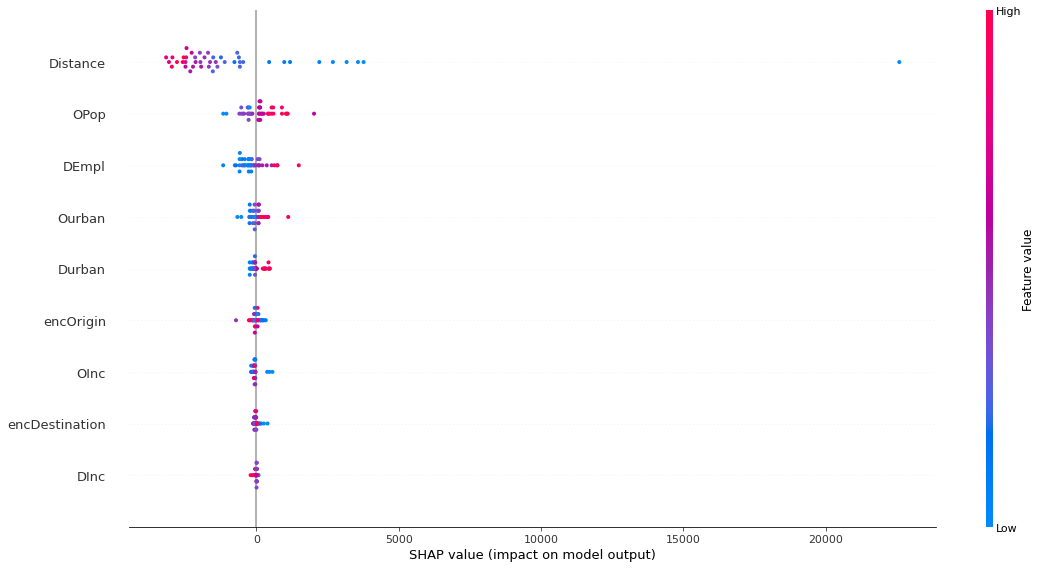

In [ ]:
shap.initjs()
shap.summary_plot(sv, x_test, plot_size=(16,8))

In [ ]:
shap.initjs()
shap.summary_plot(sv, x_test, plot_size=(16,8), show=False)
plt.savefig('summary-scatter.png')
plt.close()

Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

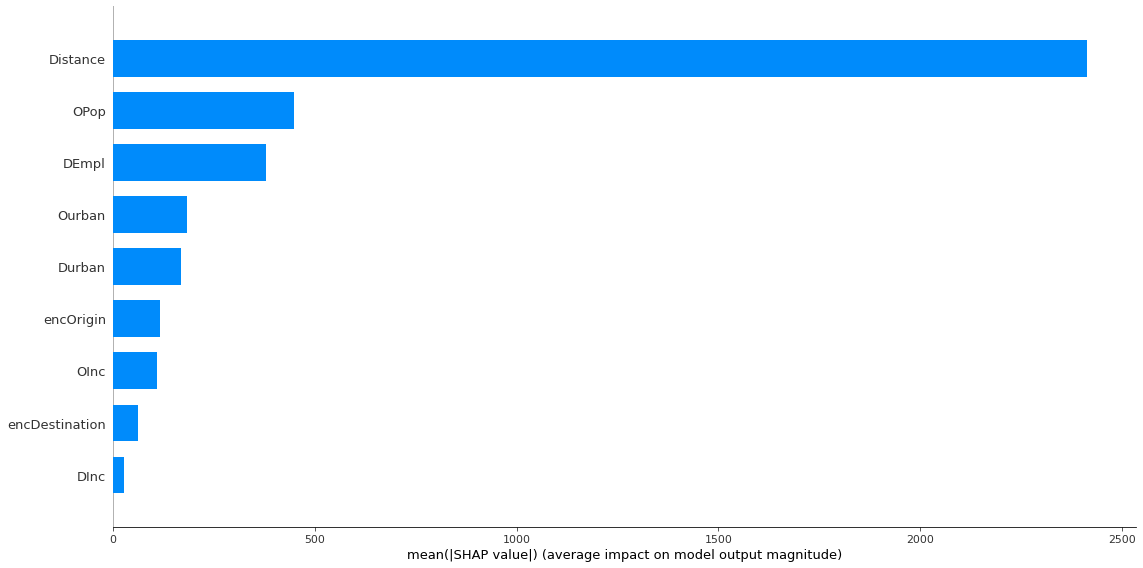

In [ ]:
shap.initjs()
shap.summary_plot(explainer(x_test), plot_type='bar', plot_size=(16,8))

In [ ]:
shap.initjs()
shap.summary_plot(explainer(x_test), plot_type='bar', plot_size=(16,8), show=False)
plt.savefig('global feature importance.png')
plt.close()

## Waterfall
It display explanations for individual predictions, so single row of an Explanation object is provided as an input. The bottom of a waterfall plot starts as the EV/base value/reference value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

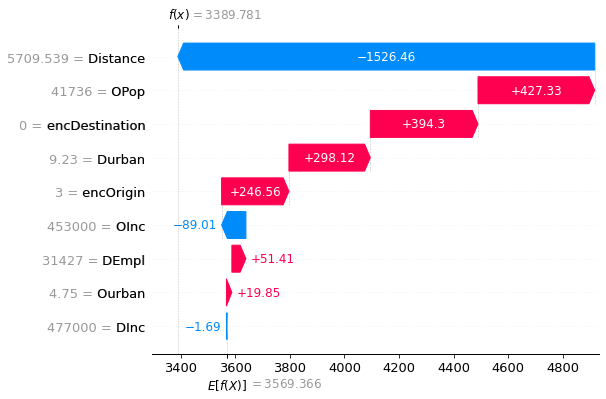

In [ ]:
shap.plots.waterfall(explainer(x_test)[0])

In [ ]:
shap.plots.waterfall(explainer(x_test)[0], show=False)
plt.savefig('watterfall.png')
plt.close()

## Force plots
visualize the first prediction's explanation The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

The SHAP force plot shows you exactly which features had the most influence on the model’s prediction for a single observation. The force plot is another way to see the effect each feature has on the prediction, for a given observation. In this plot the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. 
* The bold/highlighted value is the prediction for that observation. 
* The base value is the average of all output values of the model on the training. In other words, it is the mean prediction]
* Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
* The lighter color(blue or red) features in the plot example are many with small (low importance) values. The plot stacked them all together and shows their values on hover. The values you see are those raw values I mentioned above. They represent how much those features influence the final output of the model for the sample under study.




In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, sv[0,:], x_test.iloc[0,:])

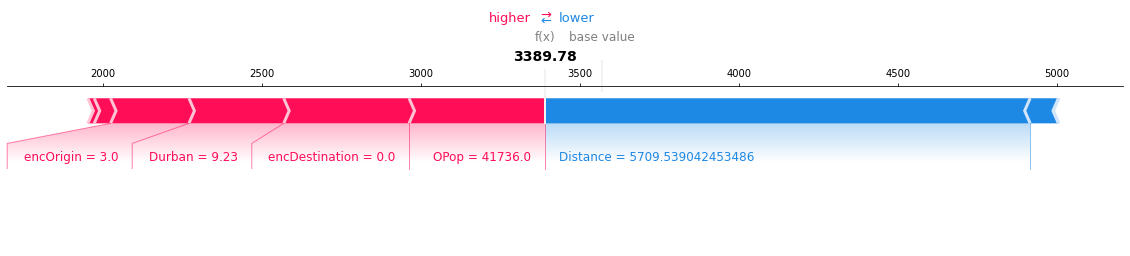

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, sv[0,:], x_test.iloc[0,:], matplotlib=True, show=False)
plt.savefig("forceplot.png", bbox_inches='tight')

In [ ]:
shap.initjs()
# visualize the training set predictions
shap.force_plot(explainer.expected_value, sv, x_test)

In [ ]:
shap.initjs()
p = shap.plots.force(explainer.expected_value, sv, x_test, show=False)
# plt.savefig("distance_forceplot.png", bbox_inches='tight')
shap.save_html('my_force_plot.html', p)

## Dependence plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.
* Each dot is a single prediction (row) from the dataset.
* The x-axis is the value of the feature (from the X matrix).
* The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. For this model the units are log-odds of that feature
* The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

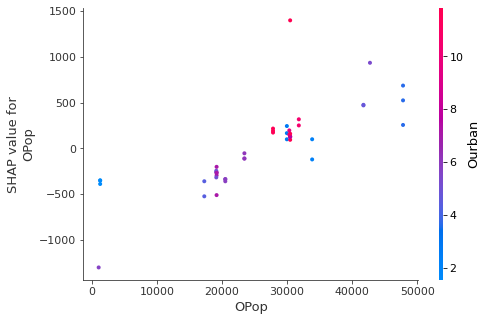

In [ ]:
# The dependence plot for the top feature shows that XGBoost captured most the linear relationship

shap.dependence_plot(0, sv, x_test)

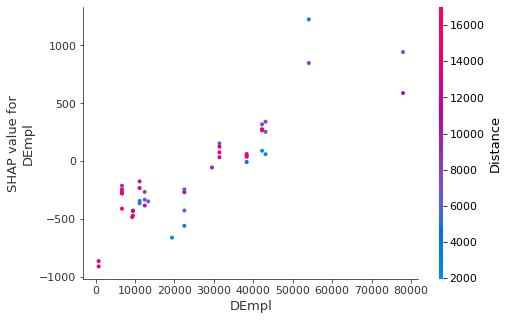

In [ ]:
shap.dependence_plot(1, sv, x_test)

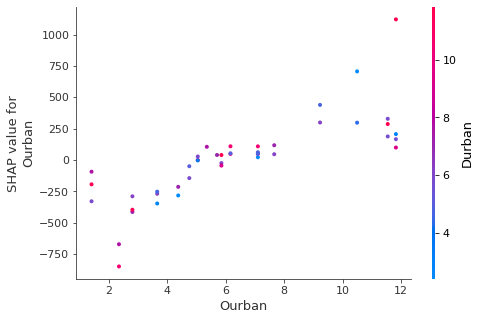

In [ ]:
shap.dependence_plot(2, sv, x_test)

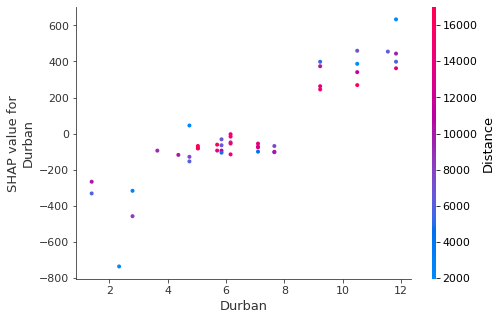

In [ ]:
shap.dependence_plot(3, sv, x_test)

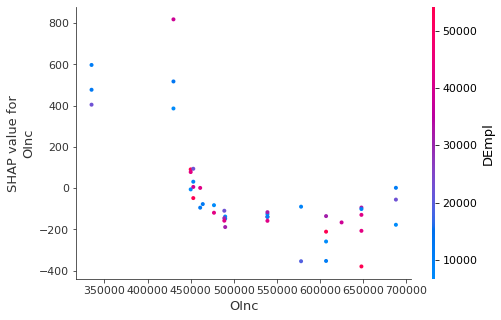

In [ ]:
shap.dependence_plot(4, sv, x_test)

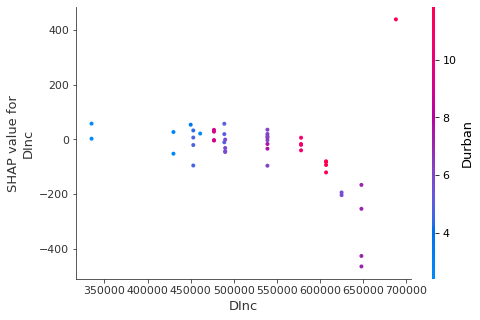

In [ ]:
shap.dependence_plot(5, sv, x_test)

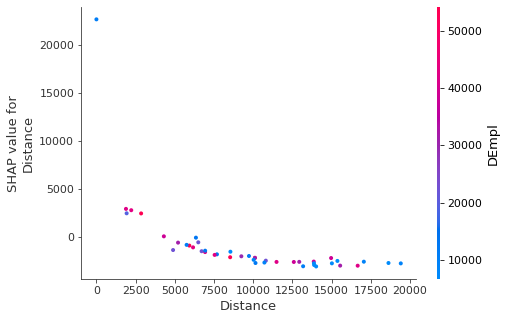

In [ ]:
shap.dependence_plot(6, sv, x_test)

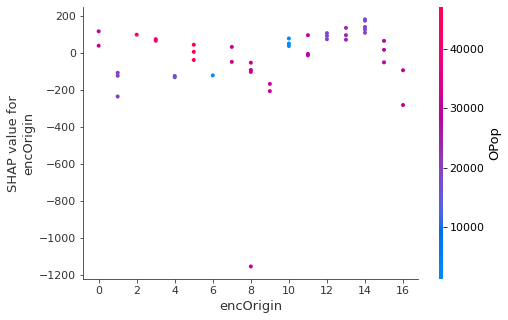

In [ ]:
shap.dependence_plot(7, sv, x_test)

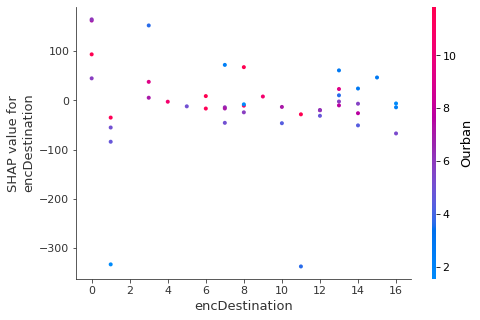

In [ ]:
shap.dependence_plot(8, sv, x_test)